In [1]:
%reset -f

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [4]:
#  获取burgers原始解数据
data = reader.loadmat('./burgers_shock.mat')

x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
Exact = np.real(data['usol'])

X, T = np.meshgrid(x, t)
X, T = X.T, T.T


x_test_np = np.concatenate((np.vstack(np.expand_dims(T, axis=2)), np.vstack(np.expand_dims(X, axis=2))), axis=-1)
x_test = torch.from_numpy(x_test_np).float().to(device)

In [5]:
# if error < self.top1:
#     self.top1 = error
#     torch.save(self.net.state_dict(), './best_model.pth')
# 载入best_model.pth
net = Net([2, 20, 20, 20, 20, 1]).to(device)
net.load_state_dict(torch.load('./best_model.pth'))

<All keys matched successfully>

In [6]:
from pyDOE import lhs
lb = np.array([0.0, -1.0])
ub = np.array([1.0, 1.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float().to(device)
    return temp

In [7]:
imgl = net(x_test).reshape([256,100]).to(device)

In [8]:
j0 = 0
J = 7
e = 0.1

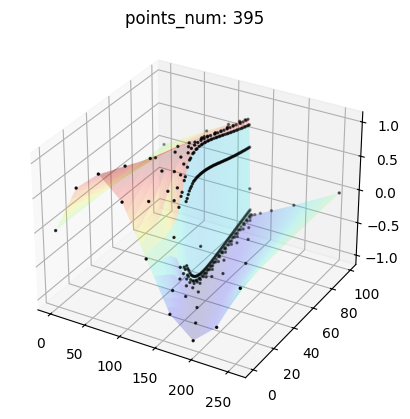

<Figure size 640x480 with 0 Axes>

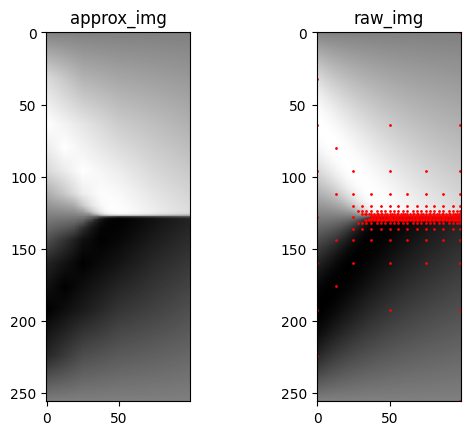

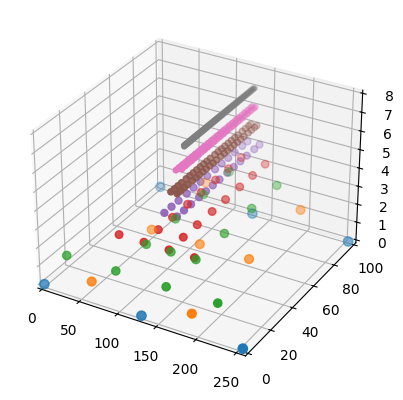

In [9]:
xc1 = torch.arange(lb[1], ub[1], 2/imgl.shape[0]).reshape((-1,1)).to(device)
xr1 = torch.arange(lb[0], ub[0], 1/imgl.shape[1]).reshape((-1,1)).to(device)
iwtmodel = utils.torchIWT(j0, J, e)
iwtmodel = iwtmodel.to(device)
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc1, xr1)
l=-1
utils.show_approx(imgl.cpu().detach().numpy(), approx.cpu().detach().numpy(), indicies, level_points=l, s=1, cmap='gray', show_2d_points=True, al=0.2)
utils.show_3d_points(approx.cpu().detach().numpy(), indicies, level_points=l)

In [10]:
err = np.linalg.norm(imgl.cpu().detach().numpy() - Exact, 2) / np.linalg.norm(Exact, 2)
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 6.5518e-04
